In [66]:
import os
import numpy as np
from pathlib import Path
import librosa
from sklearn.model_selection import train_test_split
from tsfresh.utilities.dataframe_functions import impute
from tsfresh import extract_features, select_features
from tsfresh.feature_extraction import EfficientFCParameters
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

In [67]:
RAW_DATASET_PATH = os.path.join("..", "animal_sounds")
DATASET_AUDIO_PATH = os.path.join("..", "animal_sounds_clips")
SAMPLING_RATE = 16000

In [68]:
# Get the list of audio file paths along with their corresponding labels

class_names = os.listdir(DATASET_AUDIO_PATH)
print("Our class names: {}".format(class_names,))

train_audio_paths = []
valid_audio_paths = []
train_labels = []
valid_labels = []
for label, name in enumerate(class_names):
    # print("Processing material {}".format(name,))
    dir_path = Path(DATASET_AUDIO_PATH) / name
    speaker_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.lower().endswith(".wav")
    ]
    label = label // 2 # coz every dir has a _valid copy
    if name.endswith("_valid"):
        valid_audio_paths += speaker_sample_paths
        valid_labels += [label] * len(speaker_sample_paths)
    else:
        train_audio_paths += speaker_sample_paths
        train_labels += [label] * len(speaker_sample_paths)
    # print(f"Loaded {len(speaker_sample_paths)} files from class {label}.")
    
print(
    "Found {} files belonging to {} classes.".format(len(train_audio_paths) + len(valid_audio_paths), len(class_names)//2)
)

Our class names: ['animal_ribs', 'animal_ribs_valid', 'kidney_animal', 'kidney_animal_valid', 'liver_animal', 'liver_animal_valid', 'muscle_animal', 'muscle_animal_valid', 'ribs_animal', 'ribs_animal_valid', 'skin_animal', 'skin_animal_valid']
Found 3048 files belonging to 6 classes.


In [69]:
def path_to_audio(path):
    y, _ = librosa.load(path, sr=SAMPLING_RATE)
    return y

def paths_and_labels_to_dataset(audio_paths, labels):
    """Constructs a dataset of audios and labels."""
    audios = [path_to_audio(path) for path in audio_paths]
    return np.array(audios), np.array(labels)

def to_dataframe(dataset):
    column_values = [i + 1 for i in range(len(dataset[0]))]
    df = pd.DataFrame(data=dataset, columns=column_values)
    df["id"] = df.index
    df = df.melt(id_vars="id", var_name="time").sort_values(["id", "time"]).reset_index(drop=True)
    return df
        

In [70]:
train_dataset, train_labels = paths_and_labels_to_dataset(train_audio_paths, train_labels)
test_dataset, test_labels = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)

In [71]:
X_train = to_dataframe(train_dataset)
X_test = to_dataframe(test_dataset)

In [72]:
X_train.shape, X_test.shape

((23512000, 3), (872000, 3))

In [73]:
train_to_take = 1_000_000

X_train_features = extract_features(X_train[X_train['id'] < train_to_take], column_id="id", column_sort="time", impute_function=impute, default_fc_parameters=EfficientFCParameters())
y_train = train_labels[:train_to_take]
X_test_features = extract_features(X_test, column_id="id", column_sort="time", impute_function=impute, default_fc_parameters=EfficientFCParameters())
y_test = test_labels


Feature Extraction: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [01:27<00:00,  4.58s/it]


In [74]:
X_train_features

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,value__mean_n_absolute_max__number_of_maxima_7
0,0.0,0.0,0.0,1.0,5442.851562,3703.126953,0.000983,-8.774901e-08,1.297321e-07,0.680481,...,0.228465,0.431745,1.529412,1.785538,3.146294,4.716832,6.427215,8.013261,0.0,0.715816
1,0.0,0.0,0.0,1.0,5442.875977,3703.121094,0.000944,-9.156418e-08,1.049304e-07,0.680359,...,0.894896,1.480476,3.371007,1.782008,3.132226,4.692013,6.390383,7.969342,0.0,0.689314
2,0.0,0.0,0.0,1.0,5441.557129,3701.326172,0.000941,-3.815174e-08,-7.631302e-09,0.680267,...,0.840711,1.428386,3.411888,1.781807,3.135409,4.698805,6.400765,7.988683,0.0,0.685429
3,0.0,0.0,0.0,1.0,5445.276367,3706.402344,0.001130,9.919453e-08,-9.539128e-09,0.680542,...,0.683674,1.248441,3.222679,1.787771,3.159548,4.743460,6.473279,8.066045,0.0,0.701791
4,0.0,0.0,0.0,1.0,5443.698730,3704.237793,0.000905,7.630348e-09,5.914259e-08,0.680481,...,1.299444,1.916649,3.872278,1.780366,3.128263,4.680306,6.370516,7.940130,0.0,0.685961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2934,0.0,0.0,0.0,1.0,5441.645020,3701.455322,0.001170,1.182704e-07,5.723477e-08,0.680084,...,1.266461,1.907174,3.834546,1.785307,3.143457,4.710714,6.425083,8.018189,0.0,0.695225
2935,0.0,0.0,0.0,1.0,5444.867676,3706.078613,0.002143,1.106401e-07,-1.335478e-08,0.680664,...,0.953933,1.569589,3.346926,1.781655,3.134923,4.695734,6.395577,7.976519,0.0,0.753165
2936,0.0,0.0,0.0,1.0,5445.537598,3707.047363,0.002443,1.869435e-07,5.723477e-09,0.680695,...,0.897554,1.490472,3.191544,1.784079,3.139694,4.703382,6.405064,7.985900,0.0,0.755768
2937,0.0,0.0,0.0,1.0,5446.076660,3707.793945,0.002542,0.000000e+00,-9.729911e-08,0.680786,...,0.900166,1.442432,3.264185,1.780043,3.128046,4.683497,6.378538,7.951567,0.0,0.754203


In [75]:
y_train

array([0, 0, 0, ..., 5, 5, 5])

In [76]:
relevant_features = set()

for label in np.unique(y_train):
    y_train_binary = y_train == label
    X_train_filtered = select_features(X_train_features, y_train_binary)
    print("Number of relevant features for class {}: {}/{}".format(label, X_train_filtered.shape[1], X_train_features.shape[1]))
    relevant_features = relevant_features.union(set(X_train_filtered.columns))

Number of relevant features for class 0: 201/777
Number of relevant features for class 1: 270/777
Number of relevant features for class 2: 286/777
Number of relevant features for class 3: 221/777
Number of relevant features for class 4: 386/777
Number of relevant features for class 5: 158/777


In [77]:
X_train_filtered = X_train_features[list(relevant_features)]
X_test_filtered = X_test_features[list(relobevant_features)]

In [78]:
X_train_filtered.columns = [i for i in range(X_train_filtered.shape[1])]
X_test_filtered.columns = [i for i in range(X_test_filtered.shape[1])]

In [79]:
clf = lgb.LGBMClassifier()
clf.fit(X_train_filtered, y_train)

LGBMClassifier()

In [80]:
y_pred=clf.predict(X_test_filtered)

In [81]:

accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy))

LightGBM Model accuracy score: 0.7156


In [82]:
dataset.shape, labels.shape

((2939, 8000), (2939,))

<Axes: >

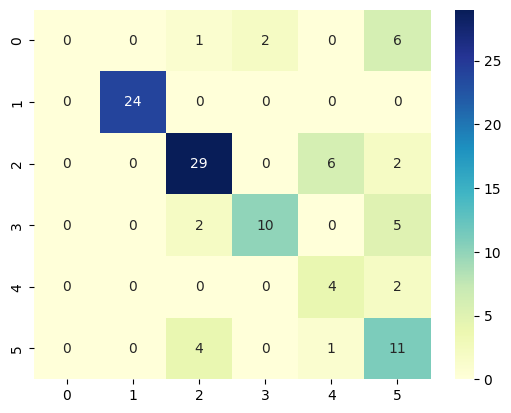

In [87]:

cm = confusion_matrix(test_labels, y_pred)
cm_matrix = pd.DataFrame(data=cm)

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')